## Introduction

The main idea behind this project is to look at recent reviews of British Airways and produce an analysis of these. The idea here is to practice web scraping as well as some NLP ideas.

In [86]:
#Import packages
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from PIL import Image

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

## Fetching the data

We now use the `BeautifulSoup` library to scrape information from https://www.airlinequality.com/airline-reviews/british-airways

In [23]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []
recommend = [] 

for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)
    try:
        response.raise_for_status()
    except Exception as e:
        print(f'There was an issue finding the website: {e}')

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}): #Fetch review text
        reviews.append(para.get_text())
    
    for x in parsed_content.find_all("div",{"class":"review-stats"}): #Fetch recommend (yes or no)
        y = x.find("table",{"class":"review-ratings"})
        para = y.find("td",{"class":"review-value rating-yes"})
        if para != None:
            recommend.append(para.get_text())
        else:
            para = y.find("td",{"class":"review-value rating-no"})
            recommend.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [25]:
df = pd.DataFrame()
df['reviews']=reviews
df['recommend']=recommend
df.head()

,reviews,recommend
0,✅ Trip Verified | Old A320 with narrow pitch....,yes
1,✅ Trip Verified | Another BA Shambles. Starte...,no
2,Not Verified | BA cancelled my flight home to...,no
3,"Not Verified | BA cancelled my flight home, t...",no
4,✅ Trip Verified | Turned up 3.5 hours in advan...,no


In [26]:
df.to_csv("BA_reviews.csv")

## Data Cleaning

*Data last collected 24/12/2022*

We now want to clean the data so that it can be sensibly processed. We first want to remove the "✅ Trip Verified |" and "Not Verified | " at the start of each review. We also want to turn the "Recommend" data into a numerical class - 1 for yes and 0 for no

In [3]:
#Load data from saved CSV - if needed
df = pd.read_csv("BA_reviews.csv")
df.drop("Unnamed: 0",axis=1, inplace=True)
df.head()

,reviews,recommend
0,✅ Trip Verified | Old A320 with narrow pitch....,yes
1,✅ Trip Verified | Another BA Shambles. Starte...,no
2,Not Verified | BA cancelled my flight home to...,no
3,"Not Verified | BA cancelled my flight home, t...",no
4,✅ Trip Verified | Turned up 3.5 hours in advan...,no


In [4]:
#Change the recommend column to numerical values
df['recommend']=df['recommend'].map(dict(yes=1, no=0))

In [5]:
df['reviews']=df['reviews'].map(lambda x : x.removeprefix("✅ Trip Verified | ").removeprefix("Not Verified | "))

## Exploratory Data Analysis

We can now start analysing the reviews

In [6]:
df.head(10)

,reviews,recommend
0,Old A320 with narrow pitch. Flight perfectly ...,1
1,Another BA Shambles. Started off well with ex...,0
2,BA cancelled my flight home to Heathrow on De...,0
3,"BA cancelled my flight home, the last flight ...",0
4,"Turned up 3.5 hours in advance, Terminal 5 at ...",0
5,Boarding – at gate at LGW they called Group 1...,0
6,Missing baggage customer service was the wors...,0
7,British Airways are not the flag carrier they...,1
8,Stupidly tried BA again after a five year gap...,0
9,Seat horribly narrow; 3-4-3 on a 777. Thankfu...,1


In [7]:
print(f"There are {df.shape[0]} reviews in total")
print(f"Of these, {df['recommend'].sum()} would recommend BA")
print(f"This means {round(100*df['recommend'].sum()/df.shape[0],2)}% are positive")

There are 1000 reviews in total
Of these, 365 would recommend BA
This means 36.5% are positive


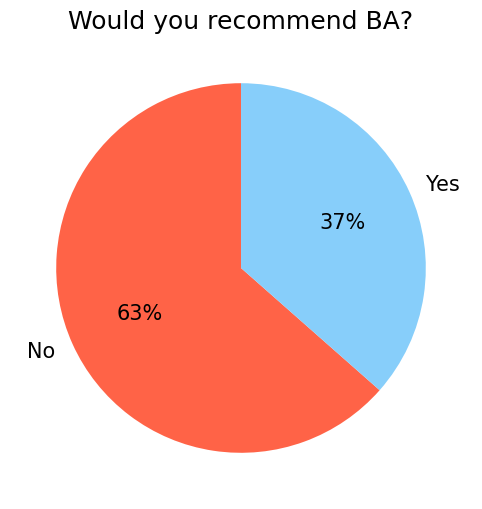

In [184]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(9,6))
labels = ["No","Yes"]
df['recommend'].value_counts().plot(kind="pie", labels=labels,colors=["tomato","lightskyblue"]
                                   , startangle=90, autopct='%1.0f%%')
plt.title("Would you recommend BA?")
plt.ylabel("")
plt.show()

Let's make some word clouds for both positive and negative reviews to see if there's some common things that are praised or criticised

In [9]:
#Check if any reviews are empty
df['reviews'].isnull().values.any()

False

In order to create the word cloud, we need to do some pre-processing of the text

In [87]:
nltk.download('punkt') #To separate into sentences

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rodri\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [88]:
nltk.download('stopwords') #So we can ignore the most common "stop" words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rodri\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [75]:
airline_words = ["flight", "london", "ba", "british", "airways","hour", "one","british airway",
                 "heathrow","gatwick", "seat","seats","airline", "good", "business", "class", "us", "get"]

In [11]:
def clean_review(review, stop_words = set(stopwords.words('english'))):
    words = word_tokenize(review.lower())
    filtered_words = []
    
    for word in words:
        if (word not in stop_words) and word.isalpha() and (word not in airline_words): #remove punctuation and stop words
            filtered_words.append(word)
            
    
    return filtered_words

In [12]:
all_words = df['reviews'].apply(clean_review)
positive_ids = df[df['recommend']==1].index
negative_ids = df[df['recommend']==0].index

In [13]:
all_words_positive_list = all_words[positive_ids]
all_words_negative_list = all_words[negative_ids]

positive_words = [word for review in all_words_positive_list for word in review]
negative_words = [word for review in all_words_negative_list for word in review]
THUMBS_UP_FILE = 'thumbs-up.png'
THUMBS_DOWN_FILE = 'thumbs-down.png'

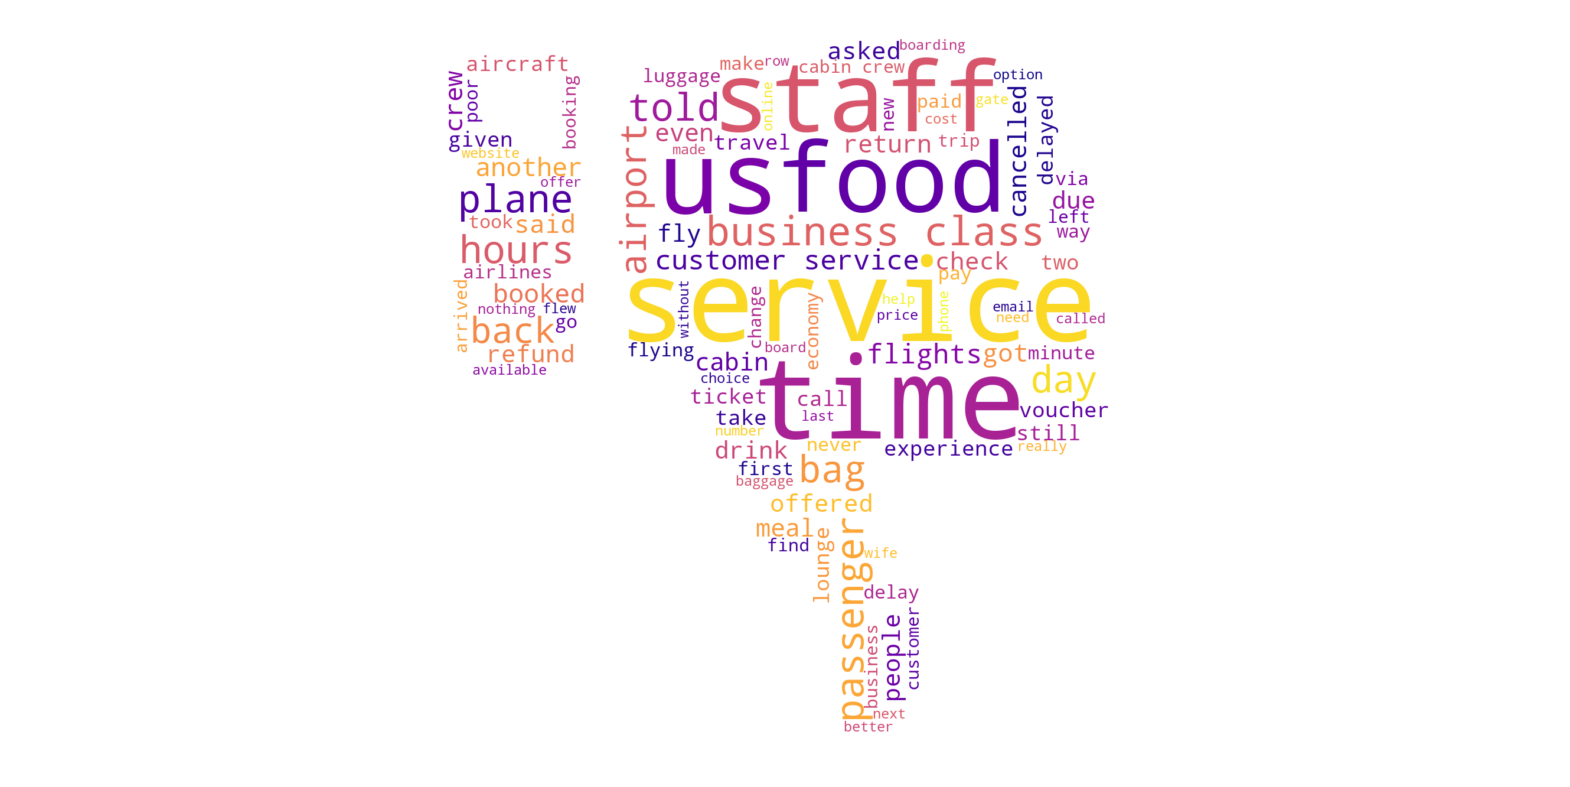

In [192]:
plt.figure(figsize=(20,20))
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255,255,255)) #All 255 in RGB gives white
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask) #Converts the image object to an np-array

wordcloud = WordCloud(width = 1000, height = 1000, mask = rgb_array,
                background_color ='white', max_words = 100,
                max_font_size = 300, colormap = 'plasma')

wordcloud.generate(" ".join(negative_words))
plt.imshow(wordcloud, interpolation='bilinear') #Interpolation smoothes the edges
plt.axis('off')

plt.show()

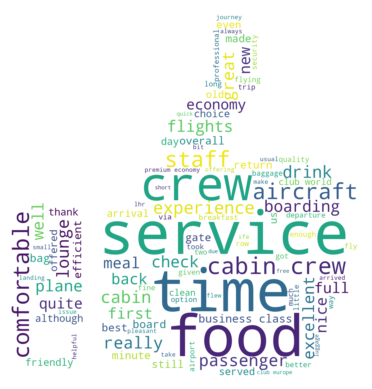

In [190]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255,255,255)) #All 255 in RGB gives white
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask) #Converts the image object to an np-array

wordcloud = WordCloud(width = 800, height = 800, mask = rgb_array,
                background_color ='white', max_words = 100,
                max_font_size = 300, colormap = 'viridis')

wordcloud.generate(" ".join(positive_words))
plt.imshow(wordcloud, interpolation='bilinear') #Interpolation smoothes the edges
plt.axis('off')

plt.show()

## Topic Analysis

In [33]:
#Top 10 most used words
all_words_list = [word for review in all_words for word in review]
all_words_list = pd.DataFrame(all_words_list)
all_words_list.value_counts().head(10)

service     724
food        517
crew        498
time        479
class       434
cabin       433
would       407
staff       399
business    382
get         338
dtype: int64

In order to process the words, we need to ensure that different inflections of the same word are treated the same. For this we use a Porter stemmer.

In [37]:
def clean_stem_review(review, stop_words = set(stopwords.words('english')), stemmer = PorterStemmer()):
    words = word_tokenize(review.lower())
    filtered_words = []
    
    for word in words:
        if (word not in stop_words) and word.isalpha() and (word not in airline_words): #remove punctuation and stop words
            stemmed_word = stemmer.stem(word)
            filtered_words.append(stemmed_word)
            
    filtered_review = ' '.join(filtered_words)
    
    return filtered_review

In [76]:
df['clean review'] = df['reviews'].apply(clean_stem_review)

In [77]:
df.head()

,reviews,recommend,clean review
0,Old A320 with narrow pitch. Flight perfectly ...,1,old narrow pitch perfectli time constant annou...
1,Another BA Shambles. Started off well with ex...,0,anoth shambl start well excel check first mid ...
2,BA cancelled my flight home to Heathrow on De...,0,cancel home dec face sensibl weather iceland a...
3,"BA cancelled my flight home, the last flight ...",0,cancel home last day tri push onto anoth citi ...
4,"Turned up 3.5 hours in advance, Terminal 5 at ...",0,turn hour advanc termin alreadi carnag peopl t...


In [78]:
df_positive = df[df['recommend']==1]
df_negative = df[df['recommend']==0]

In [79]:
# the vectorizer object will be used to transform text to vector form
# Do not include words that appear in 90%+ of reviews, or in 25% or less of reviews
vectorizer_1 = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+')
vectorizer_2 = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+')


# apply transformation
tf_positive = vectorizer_1.fit_transform(df_positive['clean review']).toarray()
tf_negative = vectorizer_2.fit_transform(df_negative['clean review']).toarray()


# tf_feature_names tells us what word each column in the matric represents
tf_positive_feature_names = vectorizer_1.get_feature_names_out()
tf_negative_feature_names = vectorizer_2.get_feature_names_out()

In [83]:
number_of_topics = 3
model_1 = LatentDirichletAllocation(n_components=number_of_topics, random_state=42)
model_2 = LatentDirichletAllocation(n_components=number_of_topics, random_state=42)

model_1.fit(tf_positive)
model_2.fit(tf_negative)

LatentDirichletAllocation(n_components=3, random_state=42)

In [90]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        #topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
          #              for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [91]:
no_top_words = 10
display_topics(model_1, tf_positive_feature_names, no_top_words)

,Topic 0 words,Topic 1 words,Topic 2 words
0,time,economi,food
1,crew,cabin,club
2,servic,crew,servic
3,arriv,would,board
4,board,premium,time
5,well,leg,first
6,staff,fli,new
7,cabin,comfort,crew
8,check,servic,loung
9,minut,aircraft,also


In [92]:
display_topics(model_2, tf_negative_feature_names, no_top_words)

,Topic 0 words,Topic 1 words,Topic 2 words
0,servic,board,book
1,food,staff,custom
2,offer,passeng,cancel
3,cabin,servic,call
4,club,crew,day
5,time,check,hour
6,crew,food,would
7,economi,plane,servic
8,use,cabin,told
9,fli,drink,time


These don't seem hugely helpful so let's try an NMF model


In [87]:
number_of_topics = 3
model_3 = NMF(n_components=number_of_topics, random_state=42, alpha=.1, l1_ratio=.5)
model_4 = NMF(n_components=number_of_topics, random_state=42, alpha=.1, l1_ratio=.5)

model_3.fit(tf_positive)
model_4.fit(tf_negative)

C:\Users\rodri\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
C:\Users\rodri\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
C:\Users\rodri\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
C:\Users\rodri\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
C:\Users\rodri\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value

NMF(alpha=0.1, l1_ratio=0.5, n_components=3, random_state=42)

In [93]:
no_top_words = 10
display_topics(model_3, tf_positive_feature_names, no_top_words)

,Topic 0 words,Topic 1 words,Topic 2 words
0,servic,economi,crew
1,board,premium,first
2,food,cabin,cabin
3,time,leg,well
4,loung,though,time
5,club,board,comfort
6,drink,bag,experi
7,offer,also,great
8,check,much,help
9,crew,help,would


In [94]:
no_top_words = 10
display_topics(model_4, tf_negative_feature_names, no_top_words)

,Topic 0 words,Topic 1 words,Topic 2 words
0,book,servic,staff
1,call,crew,bag
2,refund,food,told
3,cancel,cabin,airport
4,custom,offer,check
5,would,meal,luggag
6,servic,drink,hour
7,day,board,time
8,voucher,time,day
9,travel,passeng,delay


## Visualising Key Complaints

There seem to be three key areas that came out of negative reviews:
- Cancellations/refunds
- Quality of food/drink on board
- Issues with delays with luggage

In [105]:
def clean_stem_review_list(review, stop_words = set(stopwords.words('english')), stemmer = PorterStemmer()):
    words = word_tokenize(review.lower())
    filtered_words = []
    
    for word in words:
        if (word not in stop_words) and word.isalpha() and (word not in airline_words): #remove punctuation and stop words
            stemmed_word = stemmer.stem(word)
            filtered_words.append(stemmed_word)
            
    
    return filtered_words

In [106]:
df_negative['clean review list'] = df_negative['reviews'].apply(clean_stem_review_list)

C:\Users\rodri\AppData\Local\Temp\ipykernel_13568\118092283.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_negative['clean review list'] = df_negative['reviews'].apply(clean_stem_review_list)


In [120]:
df_negative.drop('clean review list', inplace = True, axis=1)

C:\Users\rodri\AppData\Local\Temp\ipykernel_13568\2800262009.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_negative.drop('clean review list', inplace = True, axis=1)


In [121]:
df_negative.head()

,reviews,recommend,clean review
1,Another BA Shambles. Started off well with ex...,0,anoth shambl start well excel check first mid ...
2,BA cancelled my flight home to Heathrow on De...,0,cancel home dec face sensibl weather iceland a...
3,"BA cancelled my flight home, the last flight ...",0,cancel home last day tri push onto anoth citi ...
4,"Turned up 3.5 hours in advance, Terminal 5 at ...",0,turn hour advanc termin alreadi carnag peopl t...
5,Boarding – at gate at LGW they called Group 1...,0,board gate lgw call group board world travel p...


In [172]:
#Collect data for bar chart
x = ['Quality of Food or Drink', 'Cancellations', 'Luggage']

y = []

y.append(df_negative['clean review'].apply(lambda x: ("food" in x) or ("meal" in x) or ("drink" in x)).sum())
y.append(df_negative['clean review'].apply(lambda x: ("cancel" in x) or ("voucher" in x) or ("rebook" in x)).sum())
y.append(df_negative['clean review'].apply(lambda x: ("luggag" in x) or ("bag" in x) or ("lost" in x) 
                                           or ("suitcase" in x)).sum())

In [173]:
y = [round(100*x/df_negative.shape[0],2) for x in y] #Write as a percentage

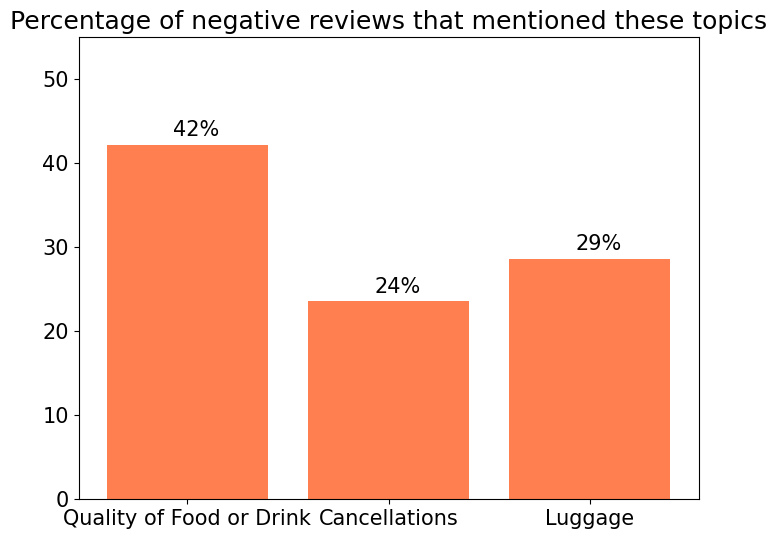

In [194]:
#Plot bar chart
plt.figure(figsize = (8,6))
plt.bar(x, y, color = 'coral')
plt.title("Percentage of negative reviews that mentioned these topics")
plt.ylim(0,55)
for i in range(3):
    plt.annotate(f"{round(y[i])}%", xy=(i-0.07,y[i]+1))

plt.show()